## Скрипт на построение BOX PLOT по заданным персентелям

Данные на вход - csv файл с полями (25 персентель, 95 персентель, 5 персентель, 75 персентель, медиана, группа данных(bin), дата)

Данные на выход - pdf файл с графиком BOX PLOT

Импорт бибилиотек

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Сортировка/чистка данных 

In [488]:
df = pd.read_csv('percentelie_balance.csv', delimiter  = ',')
df = df[df['date'] <= '2020-06-01']
df = df[df['date'] >= '2020-01-01']
df = df.sort_values(by = ['date', 'bin'])
df[df['bin'] == '9001-10000']

,softBalance_25,softBalance_95,softBalance_05,softBalance_75,Median_softBalance,hardBalance_25,hardBalance_95,hardBalance_05,hardBalance_75,Median_hardBalance,date,bin
65,166785,3601015,28450,952080,418875,493,28987,125,5370,1685,2020-01-01,9001-10000
21,220955,4506310,67680,888340,421720,655,30862,104,6660,2715,2020-02-01,9001-10000
68,161865,3611480,21790,692700,336940,620,21920,62,5940,2942,2020-03-01,9001-10000
43,163985,3398110,27120,756525,347950,965,28680,205,8066,3351,2020-04-01,9001-10000
51,188950,4930720,42005,1548270,392590,915,26060,126,6760,2915,2020-05-01,9001-10000
22,233355,5555851,56005,1461895,610685,733,26144,50,4615,2285,2020-06-01,9001-10000


Создание многомерного массива, каждый элемент массива это массив со значением данных для разных групп данных.
   
Вид:  
[   
  [  
   [1,2,3,4], Дата 1  
   [1,2,3,4,5], Дата 2  
   [3,4,5,6,7] Дата 3  
  ] Группа 1,  
  [  
   [1,2,3,4], Дата 1  
   [1,2,3,4,5], Дата 2  
   [3,4,5,6,7] Дата 3  
  ] Группа 2,  
]  
  

In [520]:
bins = df.bin.unique()
labels = df.date.unique()
data_arr = []
data_a = []
for b in bins:
    
    a = df[df['bin'] == b]
    
    
    if data_a:
        data_arr.append(data_a)
        data_a = []
    
    
    for index, row in a.iterrows(): 
        data = a[a['date'] == row['date']]
        q2 = data['hardBalance_75'] 
        q3 =  data['hardBalance_25'] 
        center = data['Median_hardBalance']
        flier_high = data['hardBalance_95']
        flier_low = data['hardBalance_05']
        data_a.append(np.concatenate((q2, q3, center, flier_high, flier_low)))
data_arr.append(data_a)

Строим график

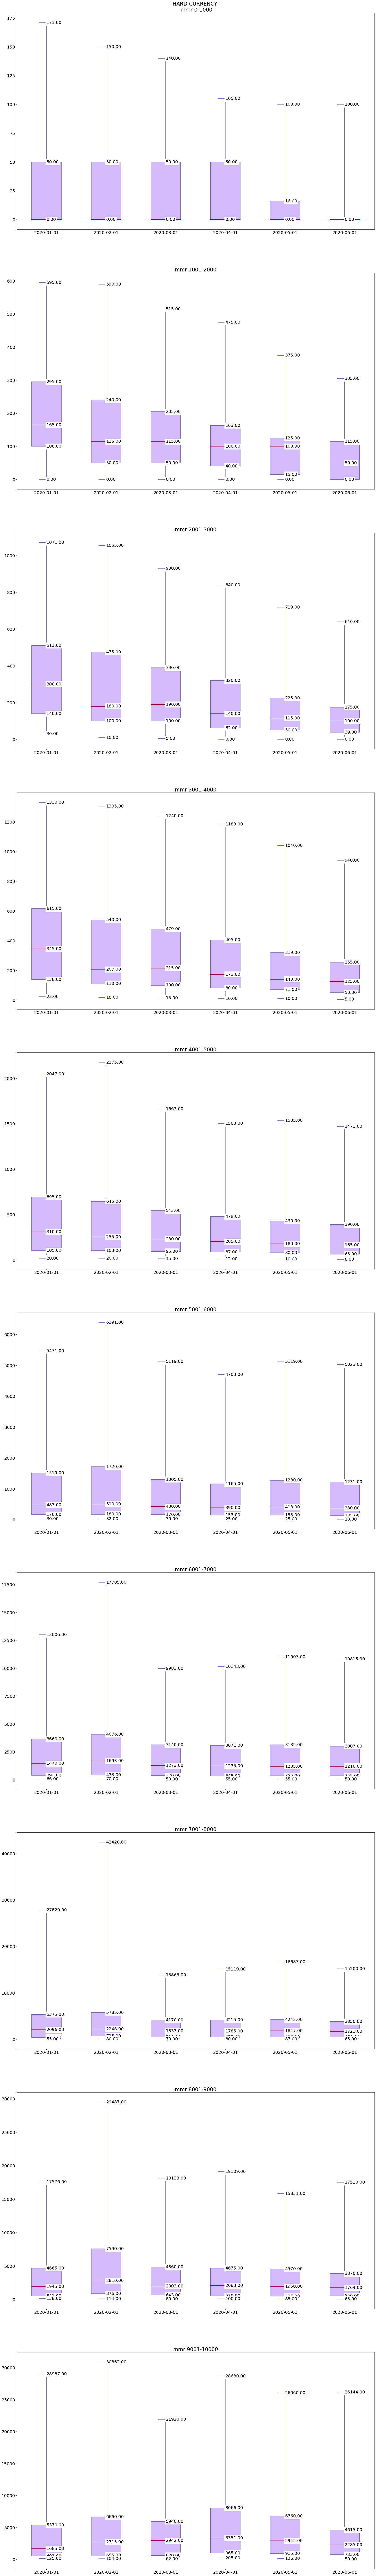

In [551]:
# размер шрифта для осей
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

blue_square = dict(markerfacecolor='b', marker='s')
fig, ax = plt.subplots(nrows=len(bins), ncols=1, figsize=(30, 220))

for data, i in zip(data_arr, range(len(ax))):
    # Поставим заголовок графику
    if i == 0:
        ax[i].set_title('HARD CURRENCY \n mmr {}'.format(bins[i]), fontsize=24)
    else:
        ax[i].set_title('mmr {}'.format(bins[i]), fontsize=24)
    
    bp = ax[i].boxplot(data, flierprops=blue_square, labels=labels, patch_artist=True)

    # Наводим красоту
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        box.set( facecolor ='#D3BBF9', linewidth=2)

    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    for item, x in zip(data, range(len(labels))):
        bp['whiskers'][2*x + 1].set_ydata([item[0], item[3]])
        # меняем данные верхней границы [2*x + 1], 
        # а если [2*x], то это нижняя граница
        bp['caps'][2*x + 1].set_ydata([item[3], item[3]])

    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    for item, median in zip(data, bp['medians']):
        median.set(color='#9E114D', linewidth=2)
        median.set_ydata([item[2], item[2]])

    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    
    # Ставим ярлыки со значением в точках 
    for element in ['whiskers', 'medians', 'caps']:
            for n, line in enumerate(bp[element]):
                # Get the position of the element. y is the label you want
                (x_l, y),(x_r, _) = line.get_xydata()
                # Make sure datapoints exist 
                # (I've been working with intervals, should not be problem for this case)
                if not np.isnan(y): 
                    if element == 'whiskers':
                        x_line_center = x_l + (x_l - x_r )/2
                    else:
                        x_line_center = x_l + (x_r - x_l )/2
                    y_line_center = y  # Since it's a line and it's horisontal
                    # overlay the value:  on the line, from center to right
                    ax[i].text(x_line_center, y_line_center, # Position
                            '%.2f' % y, # Value (3f = 3 decimal float)
                            verticalalignment='center', # Centered vertically with line 
                            fontsize=20, backgroundcolor="white")
plt.show()

Выгружаем в pgf

In [524]:
fig.savefig("hard_currency.pdf")

In [201]:
import plotly.express as px
fig = px.box(df[df['bin'] == '3001-4000'], x="date", y="Median_softBalance")
fig.show()

In [558]:
from pyathena import connect

cursor = connect(aws_access_key_id='YOUR_ACCESS_KEY_ID',
                 aws_secret_access_key='YOUR_SECRET_ACCESS_KEY',
                 s3_staging_dir='s3://aws-athena-query-results-063876326884-us-west-2',
                 region_name='us-west-2').cursor()

cursor.execute("SHOW SCHEMAS")
print(cursor.description)
print(cursor.fetchall())


Failed to execute query.
Traceback (most recent call last):
  File "c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\pyathena\common.py", line 232, in _execute
    query_id = retry_api_call(
  File "c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\pyathena\util.py", line 344, in retry_api_call
    return retry(func, *args, **kwargs)
  File "c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\tenacity\__init__.py", line 409, in call
    do = self.iter(retry_state=retry_state)
  File "c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\tenacity\__init__.py", line 356, in iter
    return fut.result()
  File "c:\users\admin\appdata\local\programs\python\python38-32\lib\concurrent\futures\_base.py", line 432, in result
    return self.__get_result()
  File "c:\users\admin\appdata\local\programs\python\python38-32\lib\concurrent\futures\_base.py", line 388, in __get_result
    raise self._except

DatabaseError: An error occurred (UnrecognizedClientException) when calling the StartQueryExecution operation: The security token included in the request is invalid.